In [169]:
import glob
import os.path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from time import time
from copy import deepcopy

In [2]:
# Load the data and create a random (but reproducible) test-train split

IMAGE_DIR = "./data/data/data"

def load():
    file_list = glob.glob(IMAGE_DIR + "/*.jpg")
    X = []
    Y = []

    for fname in file_list:
        with Image.open(fname) as img:
            np_img = np.array(img).flatten()
        label = int(os.path.split(fname)[-1].split('.')[0].split('_')[3])-1

        X.append(np_img)
        tempy = np.zeros(15)
        tempy[label] = 1
        Y.append(tempy)
    X, Y = np.array(X), np.array(Y)
    return X, Y

# create test, train split
X, Y = load()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.8, random_state=2021)

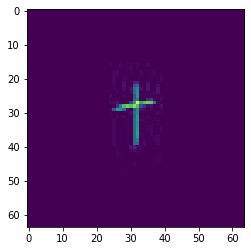

In [3]:
# Example code fyi, if you want to view samples from the dataset
plt.imshow(Xtrain[1].reshape((64,64)))

#### Scale data

In [4]:
scaler = StandardScaler(with_mean=True).fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

#### Objective

In [138]:
def f(X, Y, W, b):
    summation = 0
    for i in range(X.shape[0]):
        summation += Y[i].reshape(1,15) @ (W.reshape(15,4096) @ X[i].reshape(4096,1) + b.reshape(15,1))
        logval = np.log(np.array([1]*15).reshape(1,15) @ np.exp((W.reshape(15,4096) @ X[i].reshape(4096,1) + b.reshape(15,1))))
        summation -= logval
    return -summation/X.shape[0]

#### Gradient Descent Solver

In [6]:
def graddescent(X, Y, gradWloss, gradbloss, W1, b1, eta, a, tol):
    from IPython.display import Audio
    """
    X: input X data as nxd matrix
    Y: input Y data as nxk matrix as one hot encoding
    gradWloss(X,Y,W,b): function to calculate W loss
    gradbloss(X,Y,W,b): function to calculate b loss
    W1: Initial guess of W
    b1: Initial guess of b
    eta and a: Parameters for alpha_t = eta/(1+at)
    tol: the stopping tolerance such that max{||grad_b||_inf,||grad_W||_inf}<=tol
    """
    sequence = []
    t = 0
    w,b = W1,b1
    sequence.append((w,b))
    start = time()
    gradW = gradWloss(X,Y,w,b)
    gradb = gradbloss(X,Y,w,b)
    maxima = max(np.linalg.norm(gradW,'fro'),np.linalg.norm(gradb,'fro'))
    while maxima>tol:
        alpha = eta/(1+a*t)
        w = np.add(w,-alpha*gradW)
        b = b - alpha*(gradb.reshape(1,15))
        gradW = gradWloss(X,Y,w,b)
        gradb = gradbloss(X,Y,w,b)
        sequence.append((w,b))
        maxima = max(np.linalg.norm(gradW.flatten(),np.inf),np.linalg.norm(gradb,np.inf))
        t += 1
        if t == 500:
            print("Warning: Iteration 500 reached without convergence")
            return sequence
    
    print(f"Terminated at iteration {t} after {time()-start} seconds")
    return sequence
    

In [105]:
def softmax(X,W,b):
    linear = W @ X + b
    exp_num = np.exp(linear)
    exp_dim = np.array([1]*15) @ exp_num
    return (exp_num * exp_dim**-1).reshape(15,1)

In [114]:
def gradient_loss_W(X,Y,W,b):
    summation = np.array([[0.0] * W.shape[1]] * W.shape[0]).reshape(15,4096)
    for i in range(X.shape[0]):
        y = Y[i].reshape(15,1)
        x = X[i].reshape(4096,1)
        xt = X[i].reshape(1,4096)
        bt = b.reshape(15,1)
        summation += y @ xt
        summation -= softmax(x,W,bt) @ xt
    return (-summation/X.shape[0]).reshape(15,4096)

In [117]:
def gradient_loss_b(X,Y,W,b):
    summation = np.array([0.0]*15).reshape(15,1)
    for i in range(X.shape[0]):
        y = Y[i].reshape(15,1)
        x = X[i].reshape(4096,1)
        bt = b.reshape(15,1)
        summation += y
        summation -= softmax(x,W,bt)
    return (-summation/X.shape[0]).reshape(15,1)

#### Accuracy

In [11]:
def accuracy(X,y,w,b):
    summation = 0
    for i in range(X.shape[0]):
        prediction = (w @ X[i] + b).reshape(15,1)
        oneHot = [0]*15
        maxID,maxVal = 0,0
        for j in range(15):
            if prediction[j][0] > maxVal:
                oneHot[maxID] = 0
                maxVal = prediction[j][0]
                maxID = j
                oneHot[maxID] = 1
        y_id = np.where(y[i] == 1)[0]
        if y_id == maxID:
            summation += 1
    return summation / X.shape[0]

In [12]:
W = np.array([0.]*(4096)*(15))

In [13]:
W = W.reshape(15,4096)

In [14]:
b = np.array([0.]*15).reshape(1,15)

In [176]:
grad_weights = graddescent(Xtrain,Ytrain, gradient_loss_W, gradient_loss_b, W, b, 4, 0.01, 10**-3)

Terminated at iteration 210 after 1719.1407239437103 seconds


In [177]:
GD_f_train = [f(Xtrain,Ytrain,w[0],w[1]) for w in grad_weights]

In [178]:
GD_a_train = [accuracy(Xtrain, Ytrain, w[0], w[1]) for w in grad_weights]

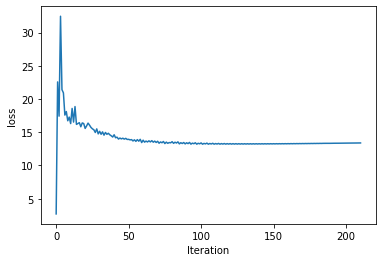

In [22]:
plt.plot(list(range(len(grad_weights))),np.array(f_vals).flatten())
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.show()

Maximum accuracy: 0.829


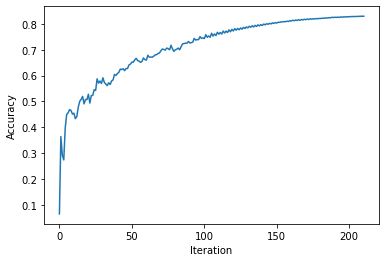

In [23]:
plt.plot(list(range(len(grad_weights))), a_vals)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
print(f"Maximum accuracy: {max(a_vals)}")
plt.show()

In [179]:
GD_f_test = [f(Xtest,Ytest,w[0],w[1]) for w in grad_weights]

In [180]:
GD_a_test = [accuracy(Xtest,Ytest,w[0],w[1]) for w in grad_weights]

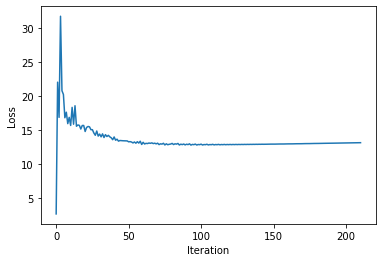

In [28]:
plt.plot([t for t in range(len(grad_weights))], np.array(f_vals).flatten())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Maximum accuracy: 0.44433333333333336


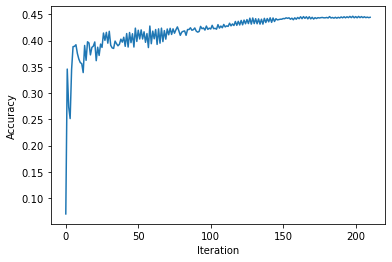

In [30]:
plt.plot([t for t in range(len(grad_weights))], a_vals)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
print(f"Maximum accuracy: {max(a_vals)}")
plt.show()

#### Backtracing Line Search

In [155]:
def backtrack(X,Y,loss,gradW,gradb,w,b,c,beta):
    alpha = 1
    alpha_count = 0
    grad2 = -np.linalg.norm(gradW, ord="fro") ** 2 - np.linalg.norm(gradb) ** 2
    hard_loss = loss(X,Y,w,b)
    while True:
        step_loss = loss(X,Y,w-alpha*gradW,b-alpha*gradb.reshape(1,15))
        curve = c * alpha * grad2
        if step_loss <= hard_loss + curve:
            break
        alpha = alpha * beta
        alpha_count += 1
        if alpha_count == 1000:
            print(f"Warning: t = {t}, Alpha calculated 1000 times without convergence")
            break
    return alpha, alpha_count

In [159]:
def steepestdescent(X, Y, loss, gradWloss, gradbloss, W1, b1, c, beta, tol):
    """
    X: input X data as nxd matrix
    Y: input Y data as nxk matrix as one hot encoding
    gradWloss(X,Y,W,b): function to calculate W loss
    gradbloss(X,Y,W,b): function to calculate b loss
    W1: Initial guess of W
    b1: Initial guess of b
    beta and c: Parameters for 
    tol: the stopping tolerance such that max{||grad_b||_inf,||grad_W||_inf}<=tol
    """
    grad_count = []
    weights = [(W1,b1)]
    t = 0
    w = W1
    b = b1.reshape(1,15)
    t = 0
    start = time()
    while True:
        gradW = gradWloss(X,Y,w,b)
        gradb = gradbloss(X,Y,w,b)
        maxima = max(np.linalg.norm(gradW.flatten(),np.inf),np.linalg.norm(gradb,np.inf))
        if maxima <= tol:
            break
        alpha, alpha_count = backtrack(X,Y,loss,gradW,gradb,w,b,c,beta)
#         print(f"Alpha[{t}] = {alpha} after {alpha_count} calculations. {time()-start} seconds have elapsed")
        grad_count.append(alpha_count)
#         print(f"Alpha[{t}] = {alpha} calculated after {alpha_count} calculations averaging {(time()-start)/(t+1)} seconds")
        w = np.add(w,-alpha*gradW)
        b = b.reshape(1,15) - alpha*(gradb.reshape(1,15))
        weights.append((w,b))
        t += 1
        if t%100 == 0:
            print(f"At iteration {t}, {time()-start} seconds have passed with error = {maxima-tol}")
#         if t == 500:
#             print("Warning: Iteration 500 reached without convergence")
#             print(f"At the end, {time()-start} seconds have passed")
#             return weights, grad_count
    print(f"Terminated at iteration {t} after {time() - start} seconds")
    return weights, grad_count
        

# Warning: This runs the entire dataset, taking over 5 hours to run

In [160]:
steep_weights, counts = steepestdescent(Xtrain, Ytrain, f, gradient_loss_W, gradient_loss_b, W, b, 0.3, 0.5, 10**-3)

At iteration 100, 866.6360585689545 seconds have passed with error = 0.0023932001429898056
At iteration 200, 1881.1930351257324 seconds have passed with error = 0.0016774203030658656
At iteration 300, 3189.2979714870453 seconds have passed with error = 0.0019084769847835942
At iteration 400, 4662.764021158218 seconds have passed with error = 0.0013673354143393652
At iteration 500, 6260.147832632065 seconds have passed with error = 0.001016779514322547
At iteration 600, 7962.329689025879 seconds have passed with error = 0.0007702864421255731
At iteration 700, 9661.984649419785 seconds have passed with error = 0.0005870277515077876
At iteration 800, 11294.232729196548 seconds have passed with error = 0.00044476312489615975
At iteration 900, 12981.504122018814 seconds have passed with error = 0.00033052599301928824
At iteration 1000, 14734.79018497467 seconds have passed with error = 0.00023647803859098418
At iteration 1100, 16212.546670913696 seconds have passed with error = 0.0001574979

In [173]:
SD_f_train = [f(Xtrain,Ytrain,w[0],w[1]) for w in steep_weights]

In [174]:
SD_a_train = [accuracy(Xtrain, Ytrain, w[0], w[1]) for w in steep_weights]

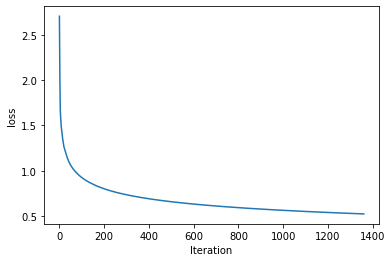

In [163]:
plt.plot(list(range(len(steep_weights))),np.array(f_vals).flatten())
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.show()

Maximum accuracy: 0.86675


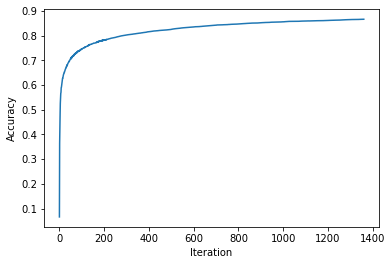

In [164]:
plt.plot(list(range(len(steep_weights))), a_vals)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
print(f"Maximum accuracy: {max(a_vals):.2%}")
plt.show()

In [171]:
SD_f_test = [f(Xtest,Ytest,w[0],w[1]) for w in steep_weights]

In [172]:
SD_a_test = [accuracy(Xtest,Ytest,w[0],w[1]) for w in steep_weights]

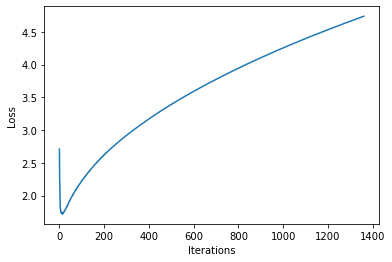

In [167]:
plt.plot(list(range(len(steep_weights))), np.array(f_vals).flatten())
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

Maximum accuracy: 0.5186666666666667


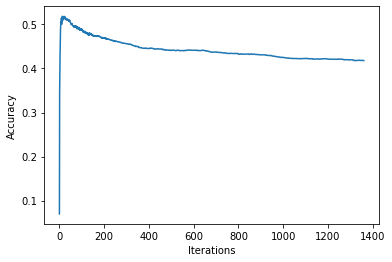

In [168]:
plt.plot(list(range(len(steep_weights))), a_vals)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
print(f"Maximum accuracy: {max(a_vals)".2%"}")
plt.show()

#### Comparative Accuracy

GD train: 82.90%
GD test:  44.43%
SD train: 86.67%
SD test:  41.80%


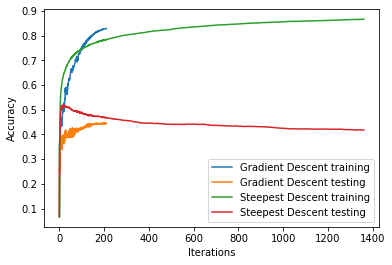

In [186]:
p1 = plt.plot([i for i in range(len(GD_a_train))], GD_a_train, label="Gradient Descent training")
p2 = plt.plot([i for i in range(len(GD_a_test))], GD_a_test, label="Gradient Descent testing")
p3 = plt.plot([i for i in range(len(SD_a_train))], SD_a_train, label="Steepest Descent training")
p4 = plt.plot([i for i in range(len(SD_a_test))], SD_a_test, label="Steepest Descent testing")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
print(f"GD train: {GD_a_train[-1]:.2%}")
print(f"GD test:  {GD_a_test[-1]:.2%}")
print(f"SD train: {SD_a_train[-1]:.2%}")
print(f"SD test:  {SD_a_test[-1]:.2%}")
plt.show()

In [203]:
expanded_alpha_counts = [sum(counts[0:i]) + counts[i] + i for i in range(len(counts))]
expanded_alpha_counts.append(expanded_alpha_counts[-1]+1)

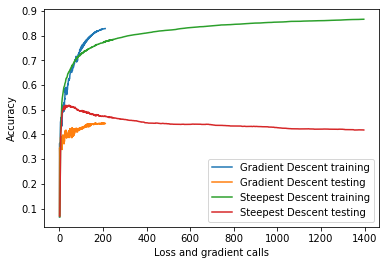

In [204]:
p1 = plt.plot([i for i in range(len(GD_a_train))], GD_a_train, label="Gradient Descent training")
p2 = plt.plot([i for i in range(len(GD_a_test))], GD_a_test, label="Gradient Descent testing")
p3 = plt.plot(expanded_alpha_counts, SD_a_train, label="Steepest Descent training")
p4 = plt.plot(expanded_alpha_counts, SD_a_test, label="Steepest Descent testing")
plt.xlabel("Loss and gradient calls")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [217]:
stochastic_sd, stochastic_counts = steepestdescent(Xtrain[0:5000], Ytrain[0:5000], f, gradient_loss_W, gradient_loss_b, W, b, 0.3, 0.5, 10**-3)

At iteration 100, 723.7426285743713 seconds have passed with error = 0.002564495302251667
At iteration 200, 1317.0210852622986 seconds have passed with error = 0.0013636106553765398
At iteration 300, 1993.2532477378845 seconds have passed with error = 0.000748077536742721
At iteration 400, 2614.3796062469482 seconds have passed with error = 0.00040924248399683456
At iteration 500, 3277.876147031784 seconds have passed with error = 0.00019126539901483238
At iteration 600, 3940.9746799468994 seconds have passed with error = 3.648105978900349e-05
Terminated at iteration 628 after 4148.953108787537 seconds


In [218]:
stochastic_accuracy = [accuracy(Xtrain,Ytrain,w[0],w[1]) for w in stochastic_sd]

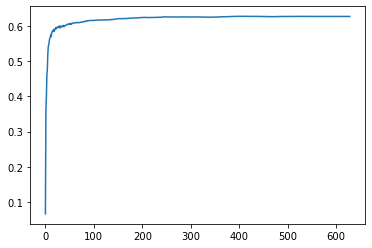

In [219]:
plt.plot([i for i in range(len(stochastic_accuracy))], stochastic_accuracy)
plt.show()